# Librerías

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
import gdown
import zipfile
from keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Preparación del entorno

In [2]:
!pip install -q gdown

In [3]:


# TP1-1-student_performance.zip
gdown.download('https://drive.google.com/uc?id=1mfpXVLqDJah-sO0CF29LjKUz5NtKjZqc')

Downloading...
From: https://drive.google.com/uc?id=1mfpXVLqDJah-sO0CF29LjKUz5NtKjZqc
To: /content/TP1-1-student_performance.zip
100%|██████████| 49.7k/49.7k [00:00<00:00, 55.0MB/s]


'TP1-1-student_performance.zip'

In [4]:


with zipfile.ZipFile('TP1-1-student_performance.zip', 'r') as zip_ref:
    zip_ref.extractall('./TP1-1')

In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

In [39]:

df = pd.read_csv('TP1-1/Student_Performance.csv')
df_original = df

# Analisis exploratorio y preprocesamiento de los datos

A continuación realizaremos el análisis exploratorio y preprocesamiento de los datos. Comenzaremos por familiarizarnos con las variables, analizando su distribución y tipo de datos y verificando la presencia de datos faltantes.

In [19]:
df.columns

Index(['Hours Studied', 'Previous Scores', 'Extracurricular Activities',
       'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index'],
      dtype='object')

In [40]:
df.columns = ['hours_studied', 'previous_scores', 'extracurricular_activities', 'sleep_hours', 'sample_question_papers_practiced', 'performance_index']

In [21]:
df.head()

,hours_studied,previous_scores,extracurricular_activities,sleep_hours,sample_question_papers_practiced,performance_index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [9]:
df.tail()

,hours_studied,previous_scores,extracurricular_activities,sleep_hours,sample_question_papers_practiced,performance_index
9995,1,49,Yes,4,2,23.0
9996,7,64,Yes,8,5,58.0
9997,6,83,Yes,8,5,74.0
9998,9,97,Yes,7,0,95.0
9999,7,74,No,8,1,64.0


In [22]:
df.describe(include=['number', 'object'])

,hours_studied,previous_scores,extracurricular_activities,sleep_hours,sample_question_papers_practiced,performance_index
count,10000.000000,10000.000000,10000,10000.000000,10000.000000,10000.000000
unique,NaN,NaN,2,NaN,NaN,NaN
top,NaN,NaN,No,NaN,NaN,NaN
freq,NaN,NaN,5052,NaN,NaN,NaN
mean,4.992900,69.445700,NaN,6.530600,4.583300,55.224800
std,2.589309,17.343152,NaN,1.695863,2.867348,19.212558
min,1.000000,40.000000,NaN,4.000000,0.000000,10.000000
25%,3.000000,54.000000,NaN,5.000000,2.000000,40.000000
50%,5.000000,69.000000,NaN,7.000000,5.000000,55.000000
75%,7.000000,85.000000,NaN,8.000000,7.000000,71.000000


In [23]:
df.isna().sum()

hours_studied                       0
previous_scores                     0
extracurricular_activities          0
sleep_hours                         0
sample_question_papers_practiced    0
performance_index                   0
dtype: int64

In [24]:
df.dtypes

hours_studied                         int64
previous_scores                       int64
extracurricular_activities           object
sleep_hours                           int64
sample_question_papers_practiced      int64
performance_index                   float64
dtype: object

# Construcción del modelo

In [41]:

# Defino un diccionario para definir el tipo de dato de cada columna
column_types = {
    'hours_studied': "numeric",
    'previous_scores': "numeric",
    'extracurricular_activities': "categoric",
    'sleep_hours': "numeric",
    'sample_question_papers_practiced': "numeric",
    'performance_index': 'False'


}

# Diccionario para almacenar media y desvío estándar de las columnas numéricas.
# Me va a servir para realizar predicciones en el futuro.
numeric_stats = {}

# Diccionario para almacenar los valores únicos de las columnas categóricas.
# Me va a servir para realizar predicciones en el futuro.
categoric_values = {}

preprocessed_df = pd.DataFrame()
preprocessed_df = pd.DataFrame()

# Preprocesamiento del set de entrenamiento
for col in column_types.keys():
    if column_types[col] == "categoric":
        num_classes = df[col].nunique()
        # Obtengo el one-hot encoding de la columna
        one_hot = pd.get_dummies(df[col], prefix=col, dtype=np.float32)
        # Agrego las columnas al dataset preprocesado
        preprocessed_df = pd.concat([preprocessed_df, one_hot], axis=1)
        # Almaceno los valores únicos
        categoric_values[col] = df[col].unique()
    elif column_types[col] == "numeric":
        # Normalizo la columna
        preprocessed_df[col] = (df[col] - df[col].mean()) / df[col].std()
        # Almaceno media y desvío estándar
        numeric_stats[col] = {
            "mean": df[col].mean(),
            "std": df[col].std()
        }
    else:
       preprocessed_df[col] = df[col]


# Agrergo la columna "Survived" al dataset preprocesado
#preprocessed_train_df["Survived"] = train_df["Survived"]

# Muestro las primeras filas del dataset preprocesado
print(preprocessed_df.head())



   hours_studied  previous_scores  extracurricular_activities_No  \
0       0.775149         1.704090                            0.0   
1      -0.383461         0.723876                            1.0   
2       1.161352        -1.063573                            0.0   
3       0.002742        -1.005913                            0.0   
4       0.775149         0.320259                            1.0   

   extracurricular_activities_Yes  sleep_hours  \
0                             1.0     1.456132   
1                             0.0    -1.492220   
2                             1.0     0.276791   
3                             1.0    -0.902549   
4                             0.0     0.866462   

   sample_question_papers_practiced  performance_index  
0                         -1.249691               91.0  
1                         -0.900937               65.0  
2                         -0.900937               45.0  
3                         -0.900937               36.0  
4    

In [42]:
preprocessed_df

,hours_studied,previous_scores,extracurricular_activities_No,extracurricular_activities_Yes,sleep_hours,sample_question_papers_practiced,performance_index
0,0.775149,1.704090,0.0,1.0,1.456132,-1.249691,91.0
1,-0.383461,0.723876,1.0,0.0,-1.492220,-0.900937,65.0
2,1.161352,-1.063573,0.0,1.0,0.276791,-0.900937,45.0
3,0.002742,-1.005913,0.0,1.0,-0.902549,-0.900937,36.0
4,0.775149,0.320259,1.0,0.0,0.866462,0.145326,66.0
...,...,...,...,...,...,...,...
9995,-1.542072,-1.178892,0.0,1.0,-1.492220,-0.900937,23.0
9996,0.775149,-0.313997,0.0,1.0,0.866462,0.145326,58.0
9997,0.388945,0.781536,0.0,1.0,0.866462,0.145326,74.0
9998,1.547556,1.588771,0.0,1.0,0.276791,-1.598446,95.0


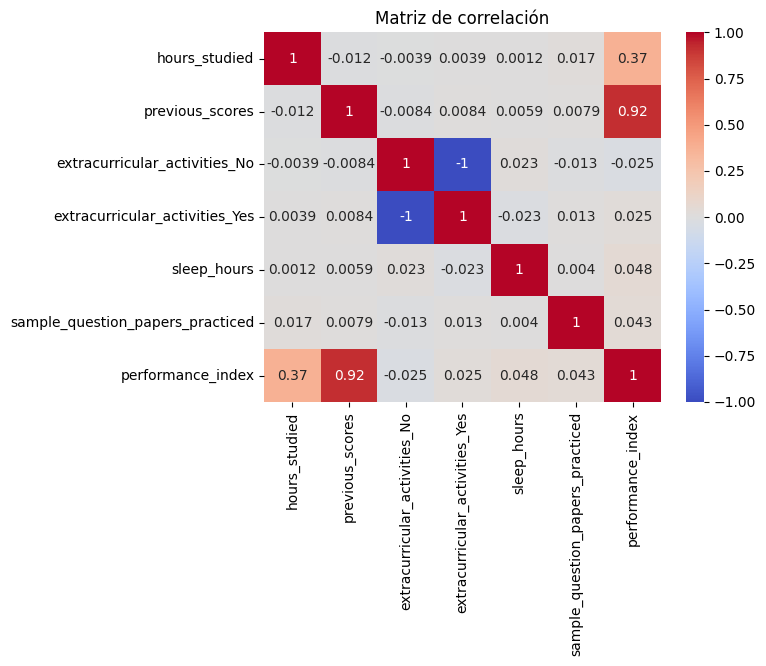

In [44]:
# Matriz de correlación
correlation_matrix = preprocessed_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Matriz de correlación")
plt.show()



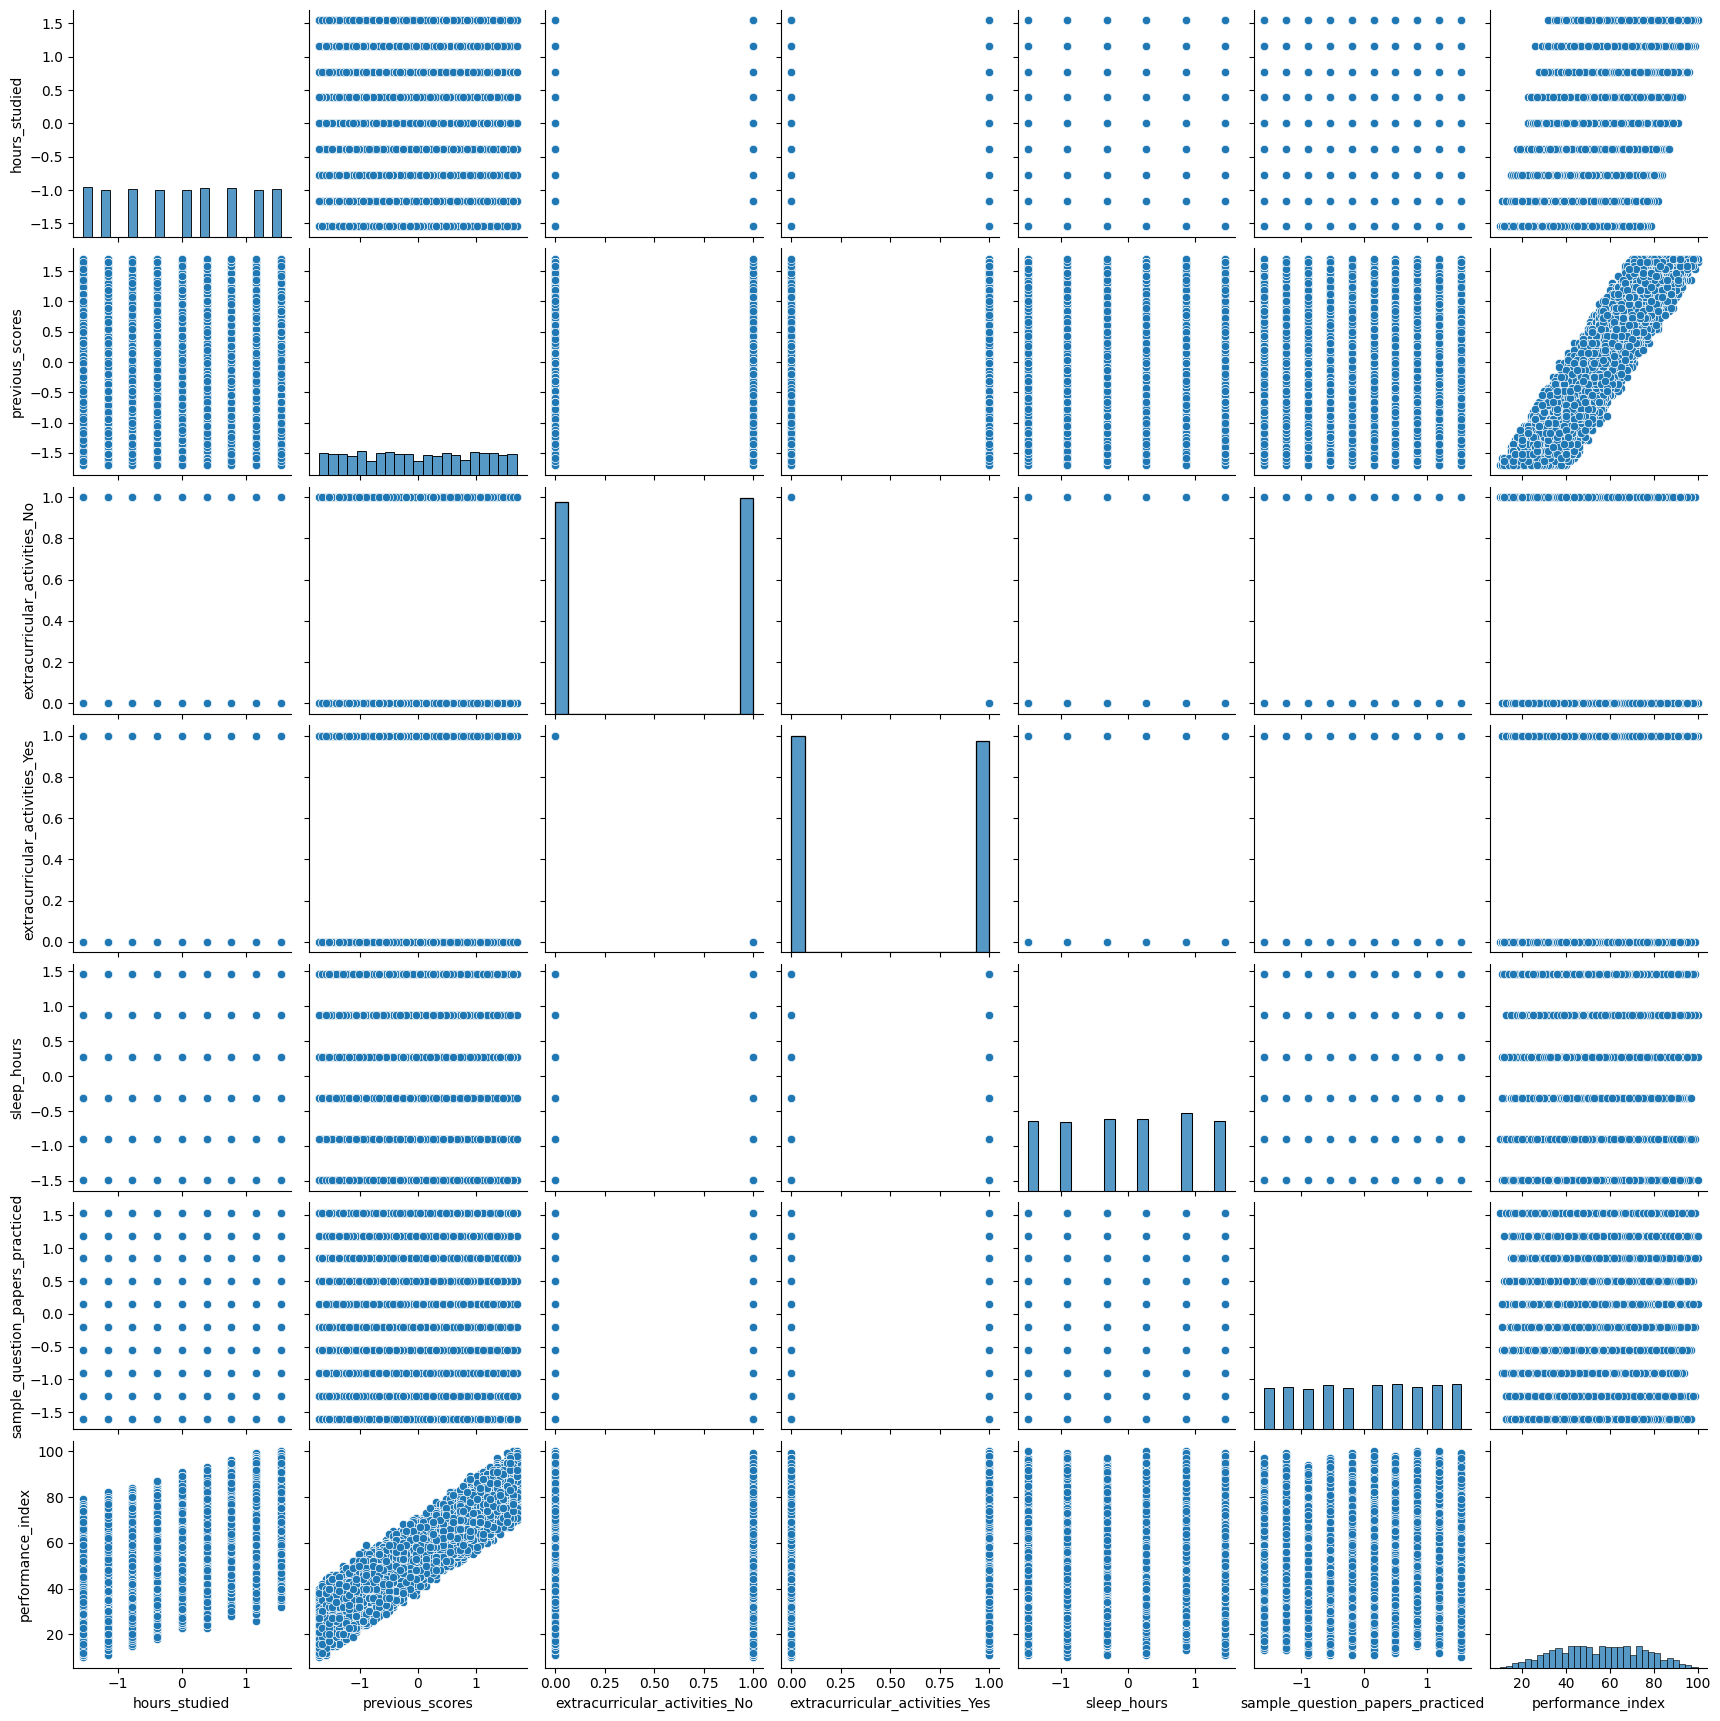

In [45]:
# Análisis entre variables
sns.pairplot(preprocessed_df)
plt.show()

In [48]:
# Obtenemos las variables independientes (X) y la variable dependiente (y)
X = preprocessed_df.drop(columns=['performance_index'])
y = preprocessed_df['performance_index']

In [49]:
# División de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [50]:
# Convertir a arrays de NumPy
X_train = X_train.values.astype(np.float32)
X_test = X_test.values.astype(np.float32)
y_train = y_train.values.astype(np.float32)
y_test = y_test.values.astype(np.float32)

In [53]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model.summary()



#Compilamos el modelo
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


# Definimos método de corte de entrenamiento cuando las métricas no mejoran
early_stopping = EarlyStopping(monitor='val_mae', patience=3, restore_best_weights=True)

# Entrenamos el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                224       
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 769 (3.00 KB)
Trainable params: 769 (3.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
200/200 [==============================] - 1s 3ms/step - loss: 2823.7971 - mae: 49.1952 - val_loss: 1404.5668 - val_mae: 33.5424
Epoch 2/50
200/200 [==============================] - 0s 2ms/step - loss: 310.7852 - mae: 12.3411 - val_loss: 23.0599 - val_mae: 3.7616
Epoch 3/50
2

Luego de probar diferentes cantidad de neuronas en las capas densas, y al ver que las métricas obtenidas no mejoraban, decidimos quedarnos con este modelo ya que desde un principio, sabiamos que era una red grande para este problema.
La métrica que elegimos para optimizar el entrenamiento fue el MAE, porque entendiamos que al ser la diferencia de las predicciones y los valores reales, era más sencillo de interpretar, descartando por ej. al accuracy, que en este problema, al ser una regresión, no nos interasaba que la predicción sea exacta.

In [56]:
# Predicciones
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'MAE: {mae}')
print(f'MSE: {mse}')

63/63 [==============================] - 0s 1ms/step
MAE: 1.6306930780410767
MSE: 4.196957588195801


# Gráficas

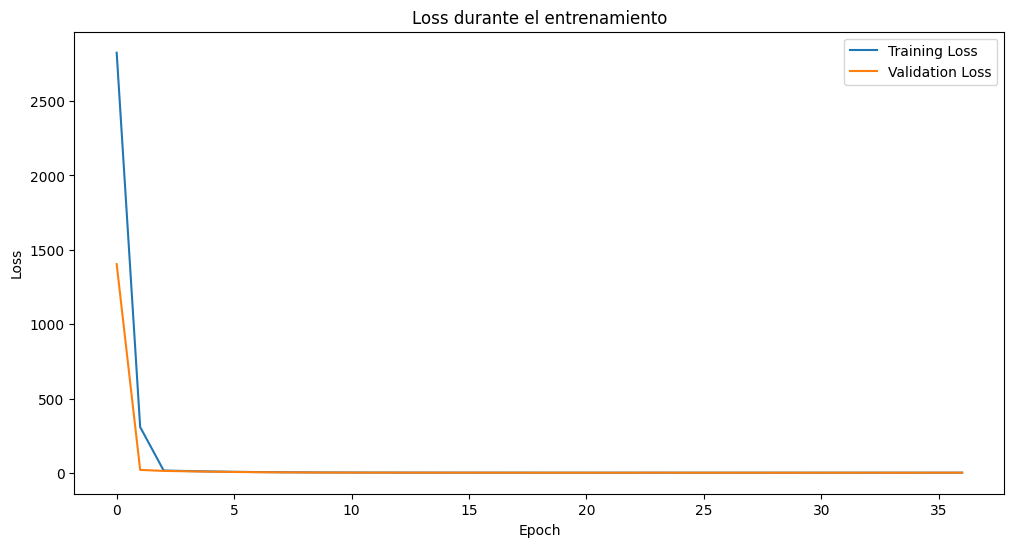

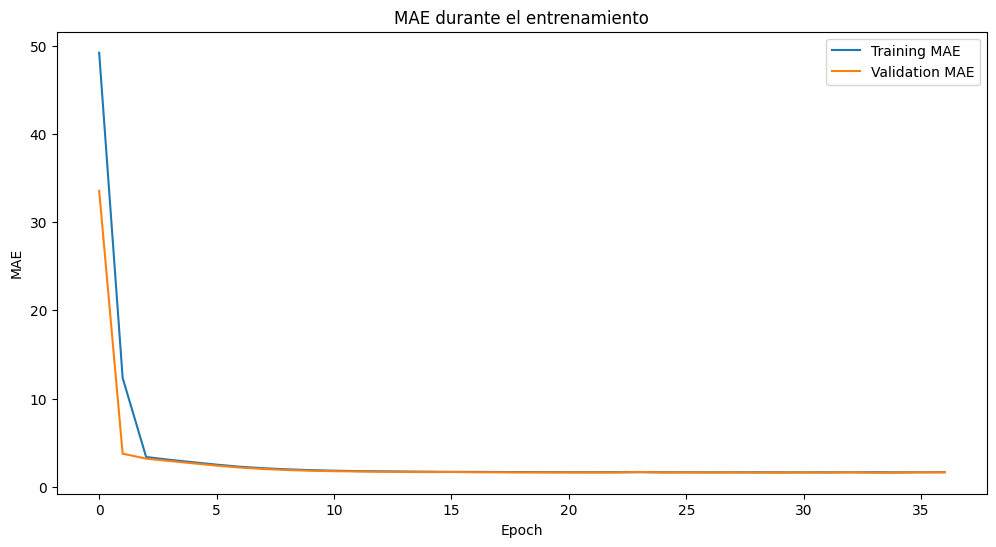

In [57]:
# Gráficos de pérdida y métricas durante el entrenamiento
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss durante el entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE durante el entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

250/250 [==============================] - 0s 1ms/step


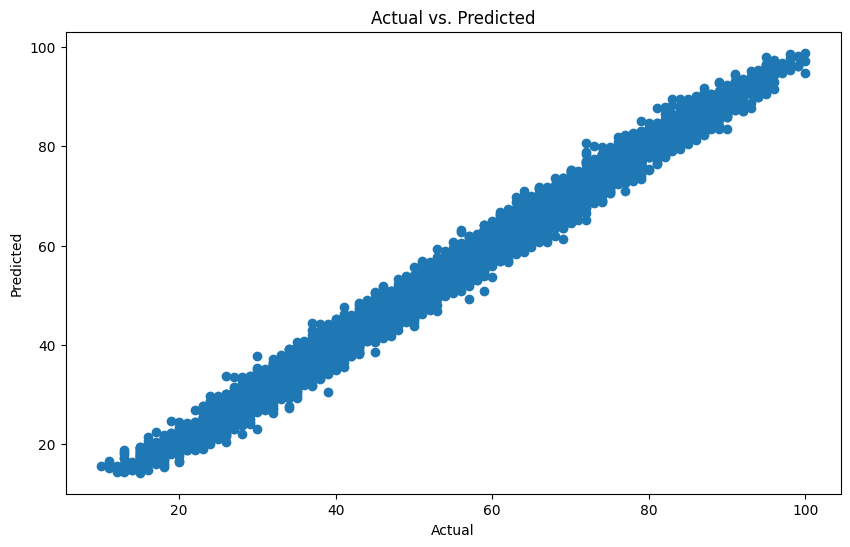

In [ ]:
# Obtener las predicciones del modelo en el conjunto de prueba
Y_pred = model.predict(X_train)

# Graficar los valores predichos vs. los valores reales
plt.figure(figsize=(10, 6))
plt.scatter(Y_train, Y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

Observando el gráfico de valores predichos vs reales, viendo que la distibución de los puntos tiene un comportamiento lineal y apoyandonos en las métricas que nos había devuelto el entrenamiento, podemos inferir que es un modelo  bastante robusto a la hora de predecir el rendimiento de los estudiantes.